In [13]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load dataset (replace with your actual file)
data = pd.read_excel('/kaggle/input/lightgbm/Data for Item Proposal_Regional-1.xlsx', sheet_name="Raw Data")

data.columns=data.columns.str.replace(' ', "_")

# Preprocess: Handle 'Month' column if it's datetime
if pd.api.types.is_datetime64_any_dtype(data['Month']):
    data['Month_Number'] = pd.to_datetime(data['Month']).dt.month
    data['Year'] = pd.to_datetime(data['Month']).dt.year
    data = data.drop('Month', axis=1)
else:
    print("Month is not datetime, treating as categorical")

# Preprocess: Encode categorical variables
data = pd.get_dummies(data, columns=['Zone_Name', 'Depot', 'Category'])

# Features and target
X = data.drop(['Net_Sales', 'Item_Name', 'Item_Code'], axis=1)
y = data['Net_Sales']

# Verify feature names
print("Feature names:", X.columns.tolist())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM model
params = {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt'}
model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)

Feature names: ['Unit_Price', 'Sales', 'Sales_Qty', 'Net_Discount', 'Month_Number', 'Year', 'Zone_Name_Barishal', 'Zone_Name_Bogura', 'Zone_Name_Chattogram', 'Zone_Name_Cumilla', 'Zone_Name_Dhaka City', 'Zone_Name_Dinajpur', 'Zone_Name_Gazipur', 'Zone_Name_Jashore', 'Zone_Name_Khulna', 'Zone_Name_Kushtia', 'Zone_Name_Mymensingh', 'Zone_Name_Rajshahi', 'Zone_Name_Rangpur', 'Zone_Name_Sylhet', 'Depot_Depot-1', 'Depot_Depot-2', 'Depot_Depot-3', 'Depot_Depot-4', 'Depot_Depot-5', 'Depot_Depot-6', 'Depot_Depot-7', 'Category_Bicycle Tube', 'Category_Bicycle Tyre', 'Category_Red Tube', 'Category_Rickshaw Tube', 'Category_Rickshaw Tyre']
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1056
[LightGBM] [Info] Number of data points in the train set: 10017, number of used feature

In [12]:
data.columns

Index(['Item_Code', 'Item_Name', 'Unit_Price', 'Sales', 'Sales_Qty',
       'Net_Discount', 'Net_Sales', 'Month_Number', 'Year',
       'Zone_Name_Barishal', 'Zone_Name_Bogura', 'Zone_Name_Chattogram',
       'Zone_Name_Cumilla', 'Zone_Name_Dhaka City', 'Zone_Name_Dinajpur',
       'Zone_Name_Gazipur', 'Zone_Name_Jashore', 'Zone_Name_Khulna',
       'Zone_Name_Kushtia', 'Zone_Name_Mymensingh', 'Zone_Name_Rajshahi',
       'Zone_Name_Rangpur', 'Zone_Name_Sylhet', 'Depot_Depot-1',
       'Depot_Depot-2', 'Depot_Depot-3', 'Depot_Depot-4', 'Depot_Depot-5',
       'Depot_Depot-6', 'Depot_Depot-7', 'Category_Bicycle Tube',
       'Category_Bicycle Tyre', 'Category_Red Tube', 'Category_Rickshaw Tube',
       'Category_Rickshaw Tyre'],
      dtype='object')

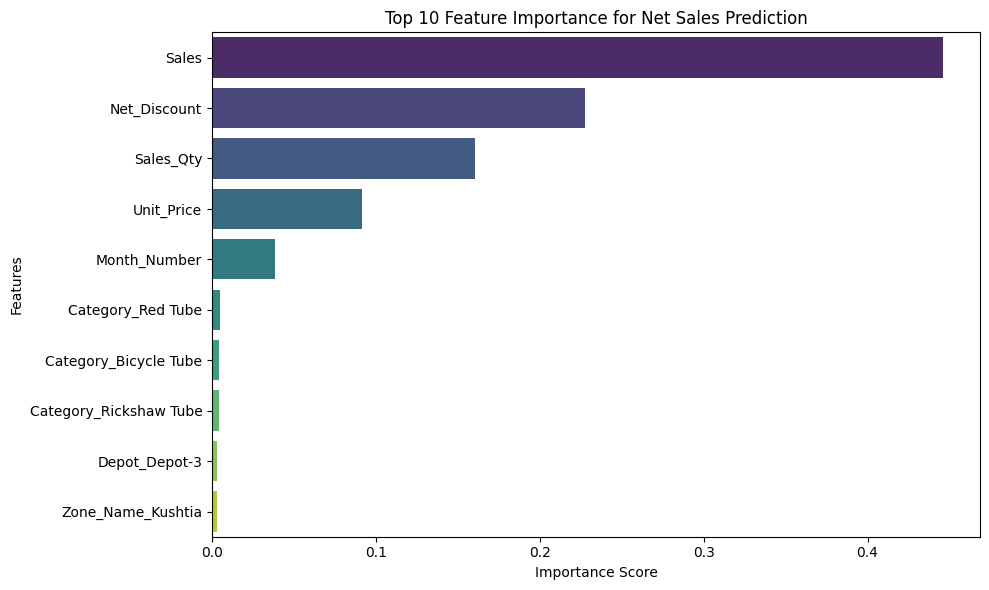

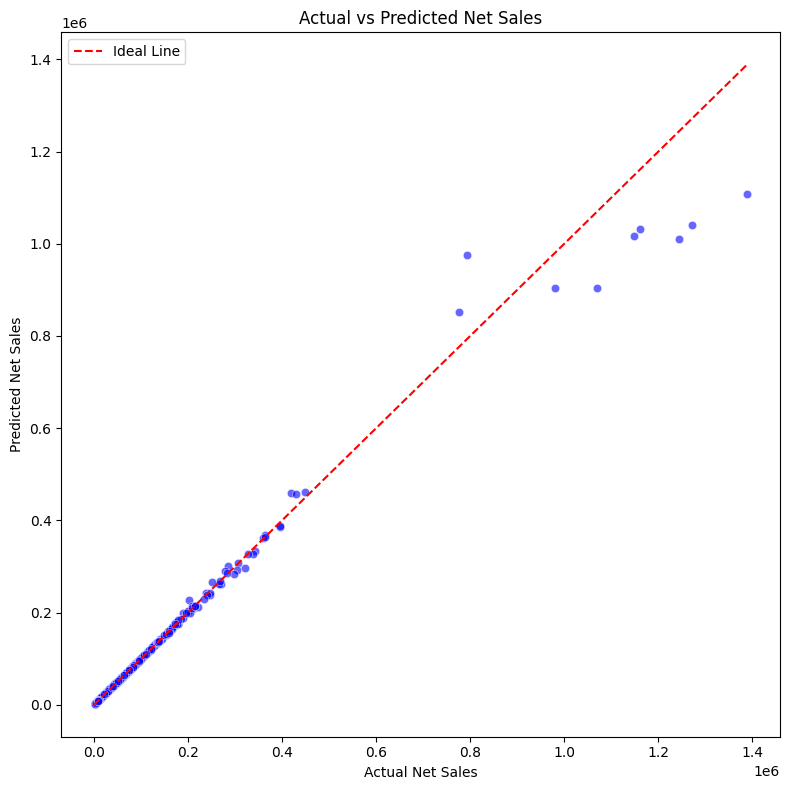

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


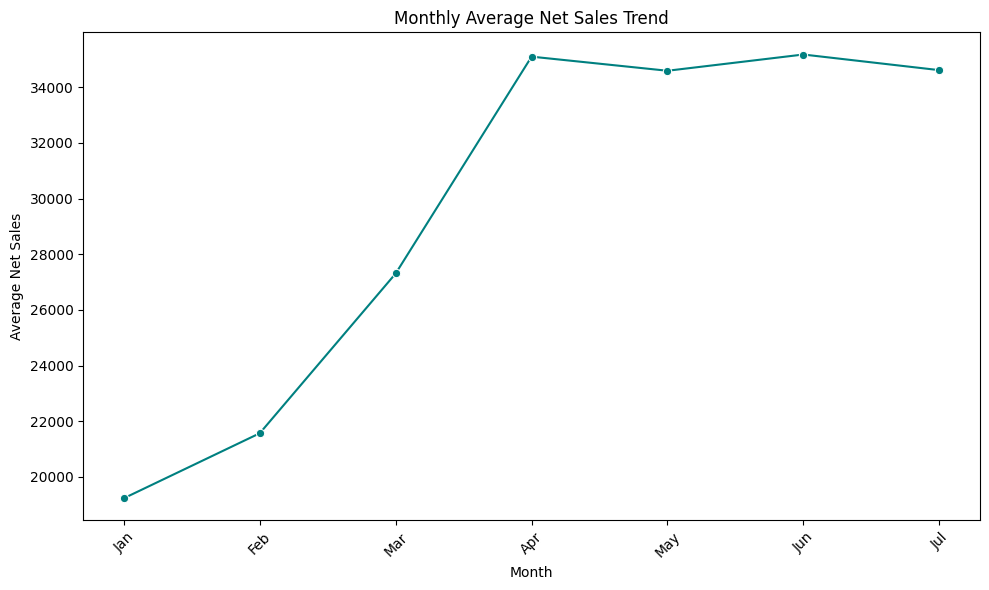

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
# --- Seaborn Visualizations ---

# 1. Feature Importance Plot
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_ / sum(model.feature_importances_)
})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Top 10 Feature Importance for Net Sales Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# 2. Actual vs. Predicted Sales Plot
actual_vs_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': predictions}).sample(2505, random_state=42)  # Sample for clarity
max_value = max(actual_vs_predicted['Actual'].max(), actual_vs_predicted['Predicted'].max())

plt.figure(figsize=(8, 8))
sns.scatterplot(x='Actual', y='Predicted', data=actual_vs_predicted, color='blue', alpha=0.6)
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', label='Ideal Line')
plt.title('Actual vs Predicted Net Sales')
plt.xlabel('Actual Net Sales')
plt.ylabel('Predicted Net Sales')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Monthly Sales Trend Plot
monthly_sales = data.groupby('Month_Number')['Net_Sales'].mean().reset_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_sales['Month_Name'] = monthly_sales['Month_Number'].map(lambda x: month_names[x-1])

plt.figure(figsize=(10, 6))
sns.lineplot(x='Month_Name', y='Net_Sales', data=monthly_sales, marker='o', color='teal')
plt.title('Monthly Average Net Sales Trend')
plt.xlabel('Month')
plt.ylabel('Average Net Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd
import numpy as np

# Calculate absolute error
errors = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Absolute_Error': np.abs(y_test - predictions),
    'Percentage_Error': np.abs((y_test - predictions) / y_test) * 100  # Avoid division by zero
})

# Option 1: Filter by absolute error threshold (e.g., errors > 1000)
threshold = 1000  # Adjust based on your data scale
large_deviations = errors[errors['Absolute_Error'] > threshold]
print("\nData points with Absolute Error >", threshold)
print(large_deviations.sort_values(by='Absolute_Error', ascending=False))

# Option 2: Filter by top 5% of errors (using percentile)
error_percentile = errors['Absolute_Error'].quantile(0.95)  # Top 5%
large_deviations_percentile = errors[errors['Absolute_Error'] > error_percentile]
print("\nTop 5% Deviated Data Points (Absolute Error >", error_percentile, ")")
print(large_deviations_percentile.sort_values(by='Absolute_Error', ascending=False))

# Optional: Merge with original test data for context
X_test_with_index = X_test.copy()
X_test_with_index['Index'] = X_test.index
large_deviations = large_deviations.merge(X_test_with_index, left_index=True, right_on='Index')
print("\nDeviated Data Points with Features:")
print(large_deviations[['Actual', 'Predicted', 'Absolute_Error', 'Percentage_Error', 'Unit_Price', 'Sales_Qty', 'Month_Number', 'Year']])


Data points with Absolute Error > 1000
          Actual     Predicted  Absolute_Error  Percentage_Error
7753   1389197.0  1.108493e+06   280703.973483         20.206204
6157   1244160.0  1.010365e+06   233795.219659         18.791411
9034   1272384.0  1.039940e+06   232443.834628         18.268371
12445   793872.0  9.760336e+05   182161.618047         22.945968
8615   1070324.0  9.045636e+05   165760.389143         15.486936
...          ...           ...             ...               ...
11249    77644.0  7.658961e+04     1054.390617          1.357981
2673     98554.0  9.751657e+04     1037.426949          1.052648
12313   158412.0  1.594400e+05     1027.973246          0.648924
4084     76136.0  7.510830e+04     1027.695852          1.349816
4191     64129.0  6.513920e+04     1010.195651          1.575256

[94 rows x 4 columns]

Top 5% Deviated Data Points (Absolute Error > 664.3864728700036 )
          Actual     Predicted  Absolute_Error  Percentage_Error
7753   1389197.0  1.10849

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


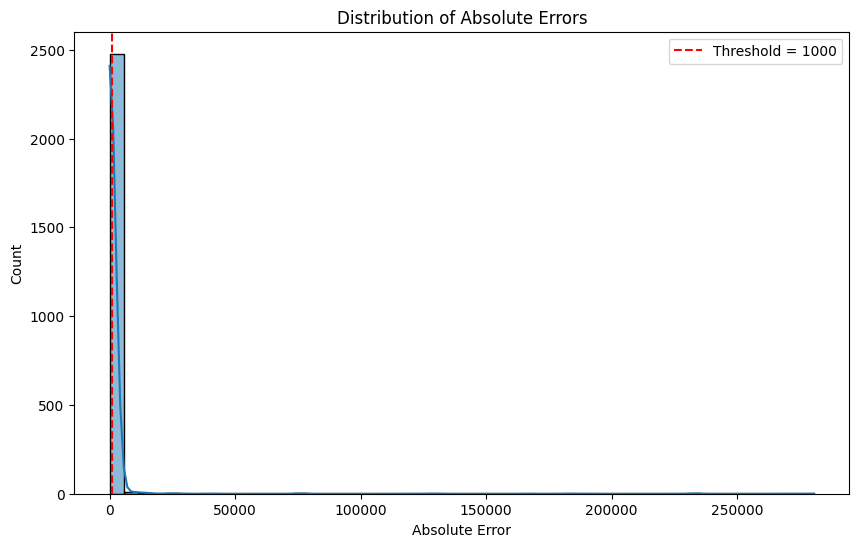

In [23]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(errors['Absolute_Error'], bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title('Distribution of Absolute Errors')
plt.xlabel('Absolute Error')
plt.legend()
plt.show()

In [24]:
import numpy as np

# Calculate absolute error (assumes errors DataFrame from previous code)
errors = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Absolute_Error': np.abs(y_test - predictions)
})

# Define standard limit (e.g., 10% of mean Net_Sales)
mean_sales = y_test.mean()
standard_limit = 0.1 * mean_sales  # Adjust percentage as needed

# Count values within standard limit
within_limit = errors[errors['Absolute_Error'] <= standard_limit]
num_within_limit = len(within_limit)
percentage_within_limit = (num_within_limit / len(errors)) * 100

print(f"Number of values within standard limit (error <= {standard_limit:.2f}): {num_within_limit}")
print(f"Percentage within limit: {percentage_within_limit:.2f}%")

Number of values within standard limit (error <= 2998.30): 2463
Percentage within limit: 98.32%


In [28]:
len(X_test)

2505

12522